# DEG error analysis

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
import upath
from helpers import deg_analysis

In [3]:
import logging

format_str = "%(asctime)s - %(name)s - %(levelname)s - %(message)s"
logging.basicConfig(format=format_str)
# logging.getLogger("gcsfs").setLevel(logging.INFO)
# logging.getLogger("fsspec").setLevel(logging.INFO)
logging.getLogger("helpers.deg_analysis").setLevel("DEBUG")
logging.captureWarnings(True)

In [4]:
paths = [
    upath.UPath("gs://liulab/differential_composition_and_expression/20230317_06h00m45s"),
    upath.UPath("gs://liulab/differential_composition_and_expression/20230410_21h06m43s"),
    # upath.UPath("gs://liulab/differential_composition_and_expression/20230505_21h41m44s"),
]

path_root = paths[0]
# print(deg_analysis.get_parquet_paths(path_root))
# !gsutil ls "{path_root}/*"
print(path_root)

gs://liulab/differential_composition_and_expression/20230317_06h00m45s


In [5]:
df_gene_stats = deg_analysis.load_gene_stats(paths)

2023-06-02 04:09:25,283 - helpers.deg_analysis.postprocessing_gene_stats_fields - DEBUG - Loading from multiple paths: [GCSPath('gs://liulab/differential_composition_and_expression/20230317_06h00m45s'), GCSPath('gs://liulab/differential_composition_and_expression/20230410_21h06m43s')]
2023-06-02 04:09:27,098 - helpers.deg_analysis.postprocessing_gene_stats_fields - DEBUG - Loading 700 parquet files
2023-06-02 04:12:08,247 - helpers.deg_analysis.postprocessing_gene_stats_fields - DEBUG - Setting ordering for malignant_means
2023-06-02 04:12:16,416 - helpers.deg_analysis.postprocessing_gene_stats_fields - DEBUG - Setting ordering for log2_fc
2023-06-02 04:12:45,760 - helpers.deg_analysis.postprocessing_gene_stats_fields - DEBUG - Grouping by ['origin', 'malignant_means', 'log2_fc', 'run_id']
2023-06-02 04:12:48,086 - helpers.deg_analysis.postprocessing_gene_stats_fields - DEBUG - Each group's size: origin                malignant_means  log2_fc  run_id
bulk                  0.55,0.85    

### checking pvals

False    16036
True        27
Name: significant_bh_fdr=0.10, dtype: int64


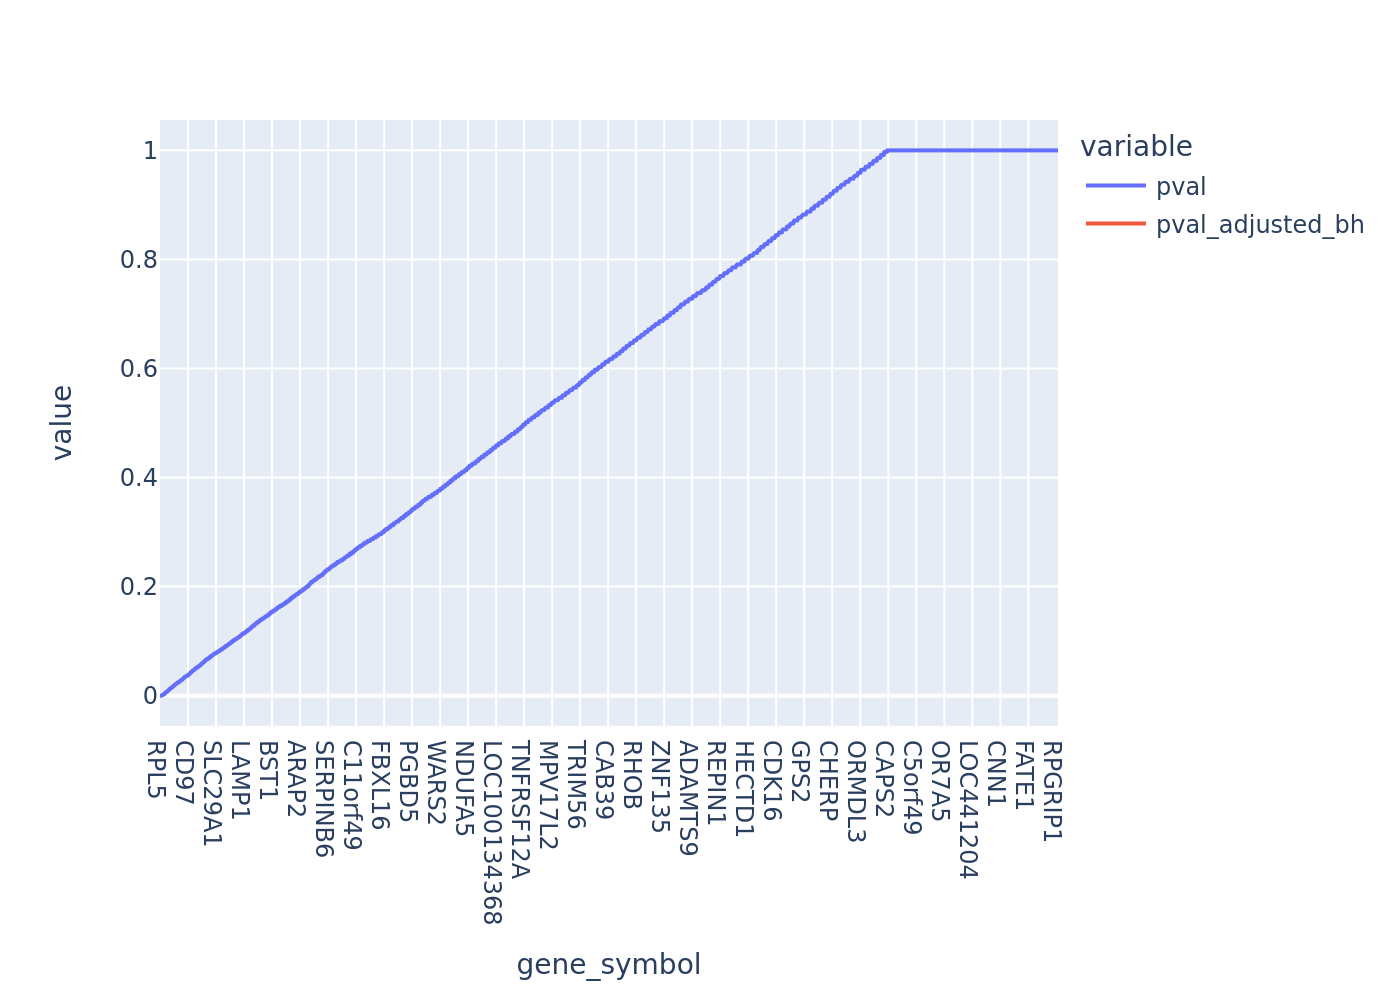

In [6]:
subset_gene_stats = df_gene_stats.loc["malignant_cibersortx", "0.72,0.7", "1.00", "04"]
# subset_gene_stats[columns].sort_values(by="-log10_pval_adjusted_bh", ascending=False)
print(subset_gene_stats["significant_bh_fdr=0.10"].value_counts())

columns = [
    "pval",
    # "-log10_pval",
    # "-log10_pval_signed_directional",
    "pval_adjusted_bh",
    # "-log10_pval_adjusted_bh",
    # "-log10_pval_adjusted_bh_signed_directional",
]
fig = px.line(
    subset_gene_stats.sort_values("pval").reset_index(),
    x="gene_symbol",
    y=columns,
)
fig.show(renderer="png", scale=2)

### volcanos for all experiment setups

2023-06-02 04:13:39,916 - helpers.deg_analysis.plotting_volcanos_v1 - DEBUG - Grouping by ['origin', 'malignant_means', 'log2_fc', 'gene_symbol', 'gene_perturbed']
2023-06-02 04:13:42,197 - helpers.deg_analysis.plotting_volcanos_v1 - DEBUG - Groups have sizes origin                malignant_means  log2_fc  gene_symbol  gene_perturbed
malignant_cibersortx  0.55,0.85        -1.50    A1BG         False             5
                                                             True              0
                                                A2M          False             5
                                                             True              0
                                                A2ML1        False             5
                                                                              ..
                      0.85,0.55        1.50     ZYX          True              0
                                                ZZEF1        False             5
                

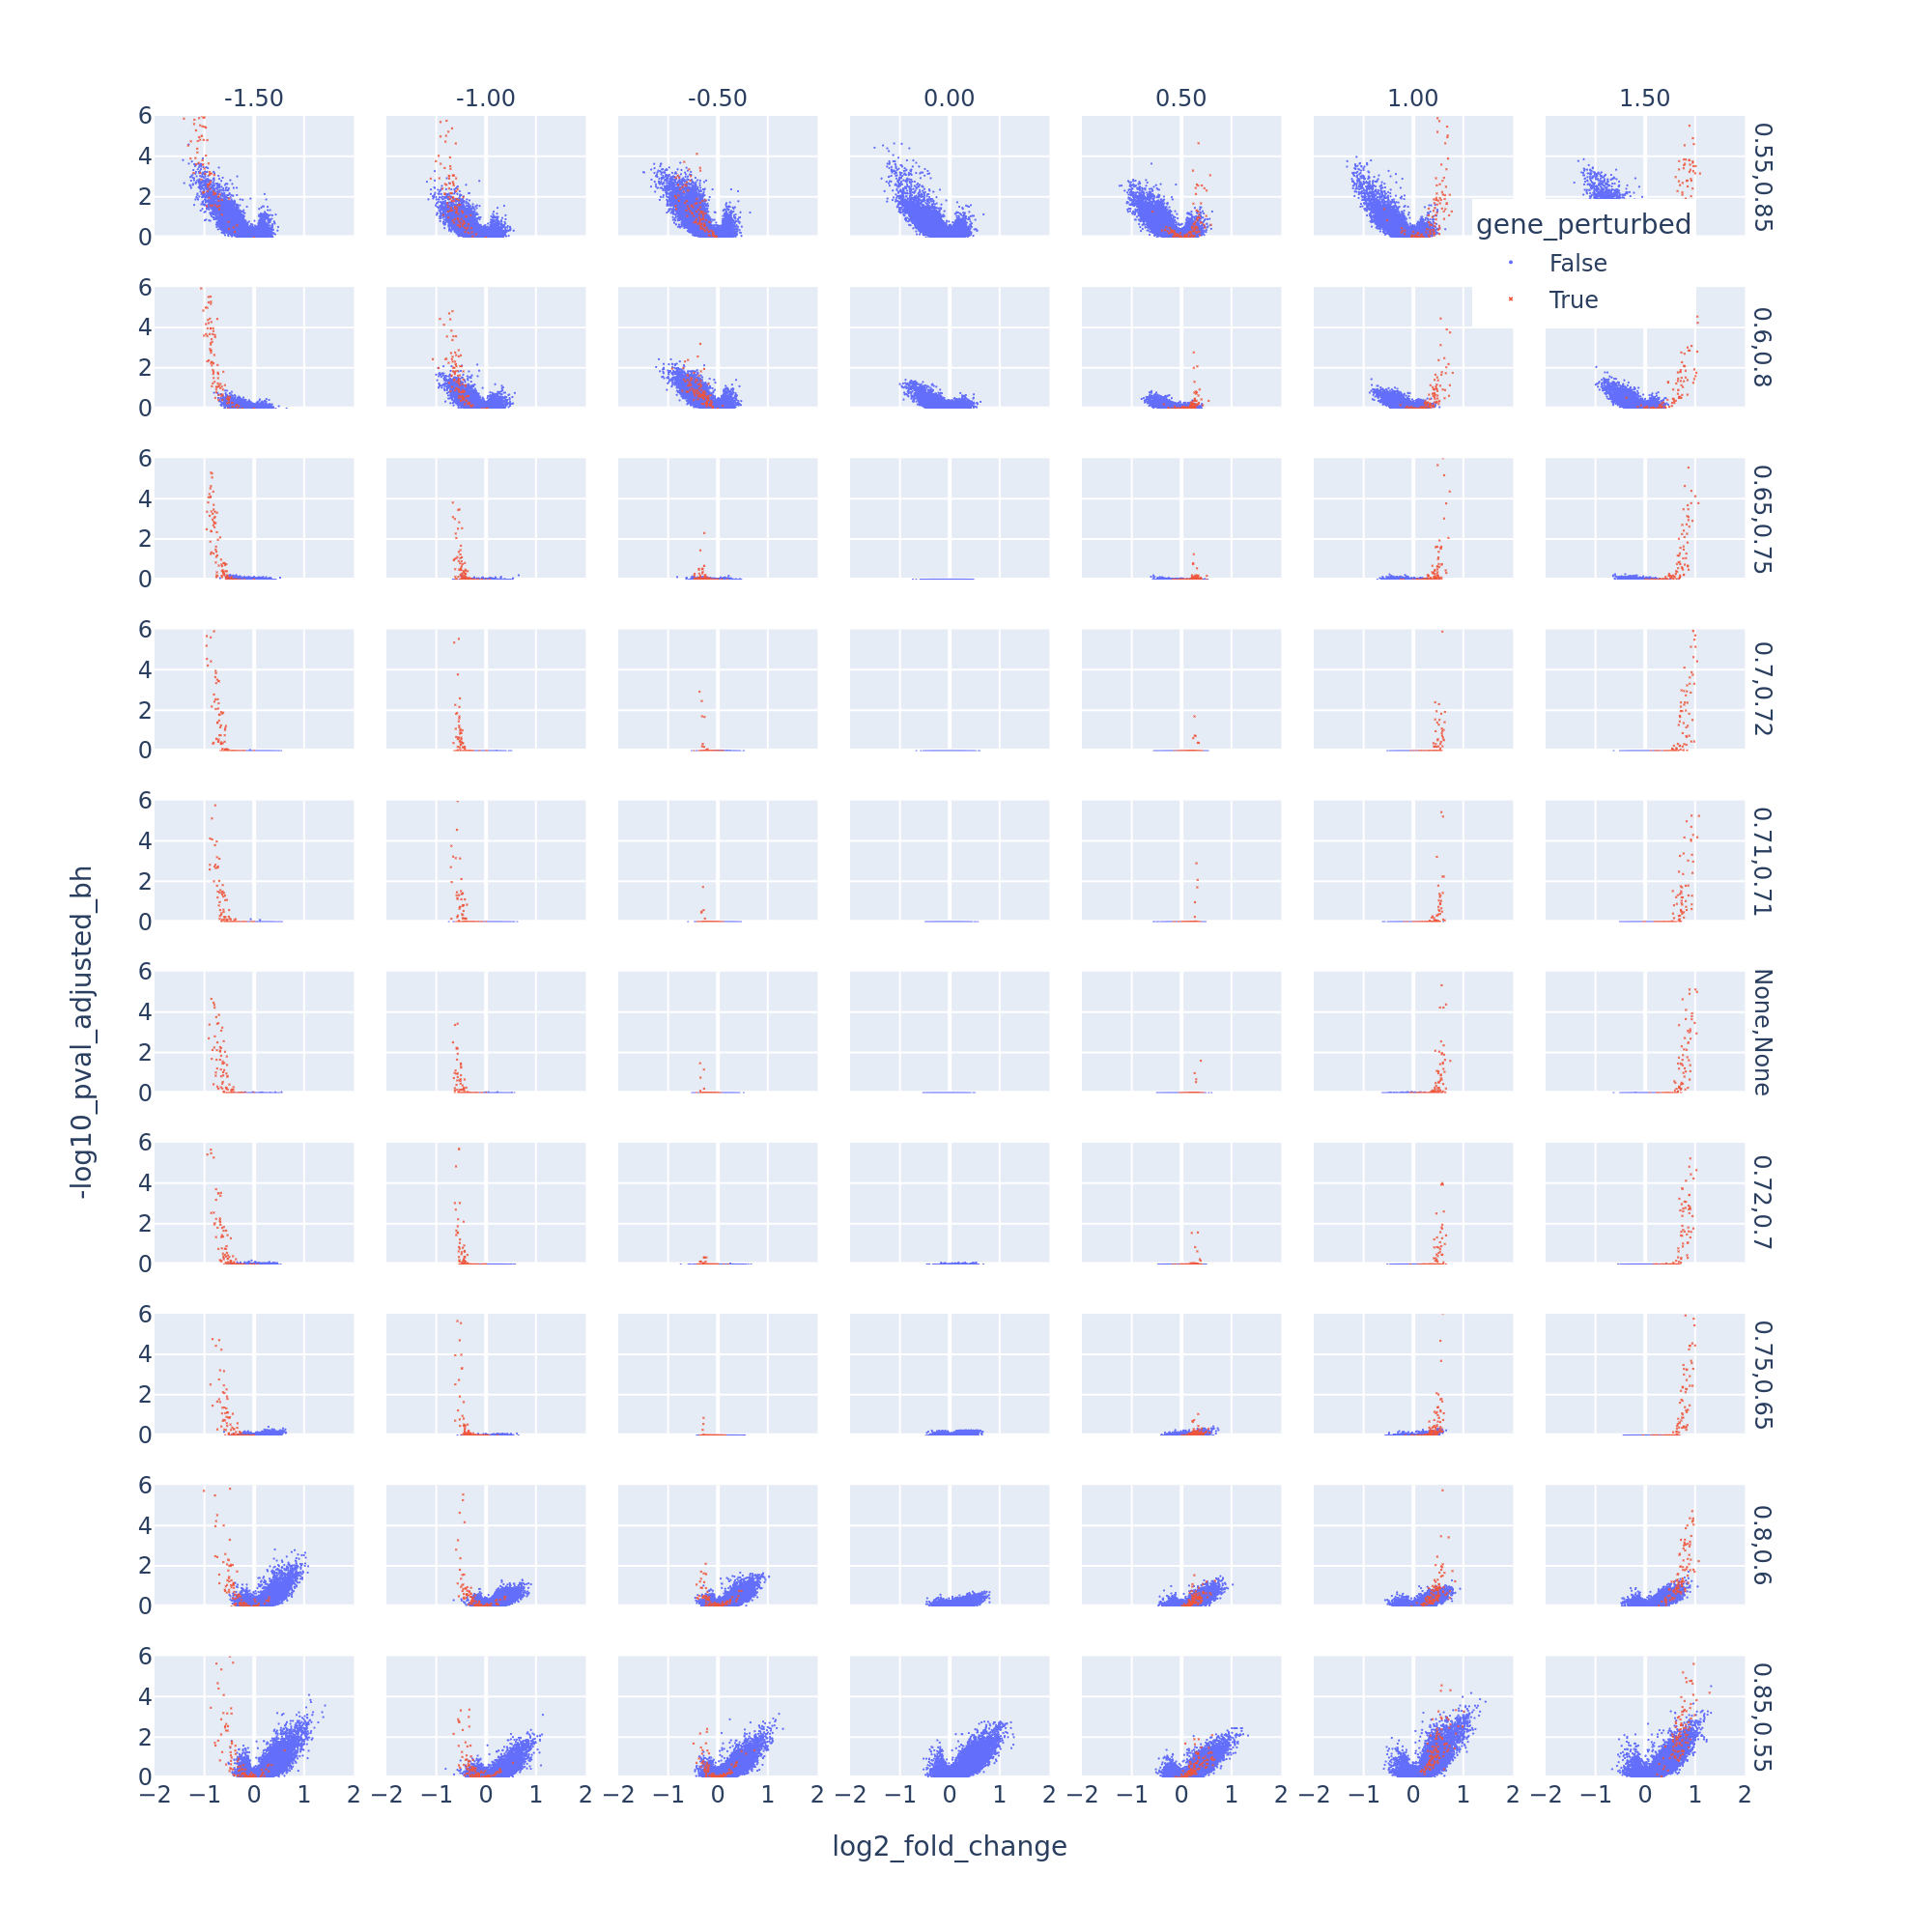

In [7]:
df_to_plot = df_gene_stats.xs("malignant_cibersortx", level="origin", drop_level=False)
fig = deg_analysis.make_volcano_grid_scatter(df_to_plot)
fig.show(renderer="png", scale=2)

2023-06-02 04:14:09,318 - helpers.deg_analysis.plotting_volcanos_v1 - DEBUG - Grouping by ['origin', 'malignant_means', 'log2_fc', 'gene_symbol', 'gene_perturbed']
2023-06-02 04:14:11,499 - helpers.deg_analysis.plotting_volcanos_v1 - DEBUG - Groups have sizes origin  malignant_means  log2_fc  gene_symbol  gene_perturbed
bulk    0.55,0.85        -1.50    A1BG         False             5
                                               True              0
                                  A2M          False             5
                                               True              0
                                  A2ML1        False             5
                                                                ..
        0.85,0.55        1.50     ZYX          True              0
                                  ZZEF1        False             5
                                               True              0
                                  ZZZ3         False             5
        

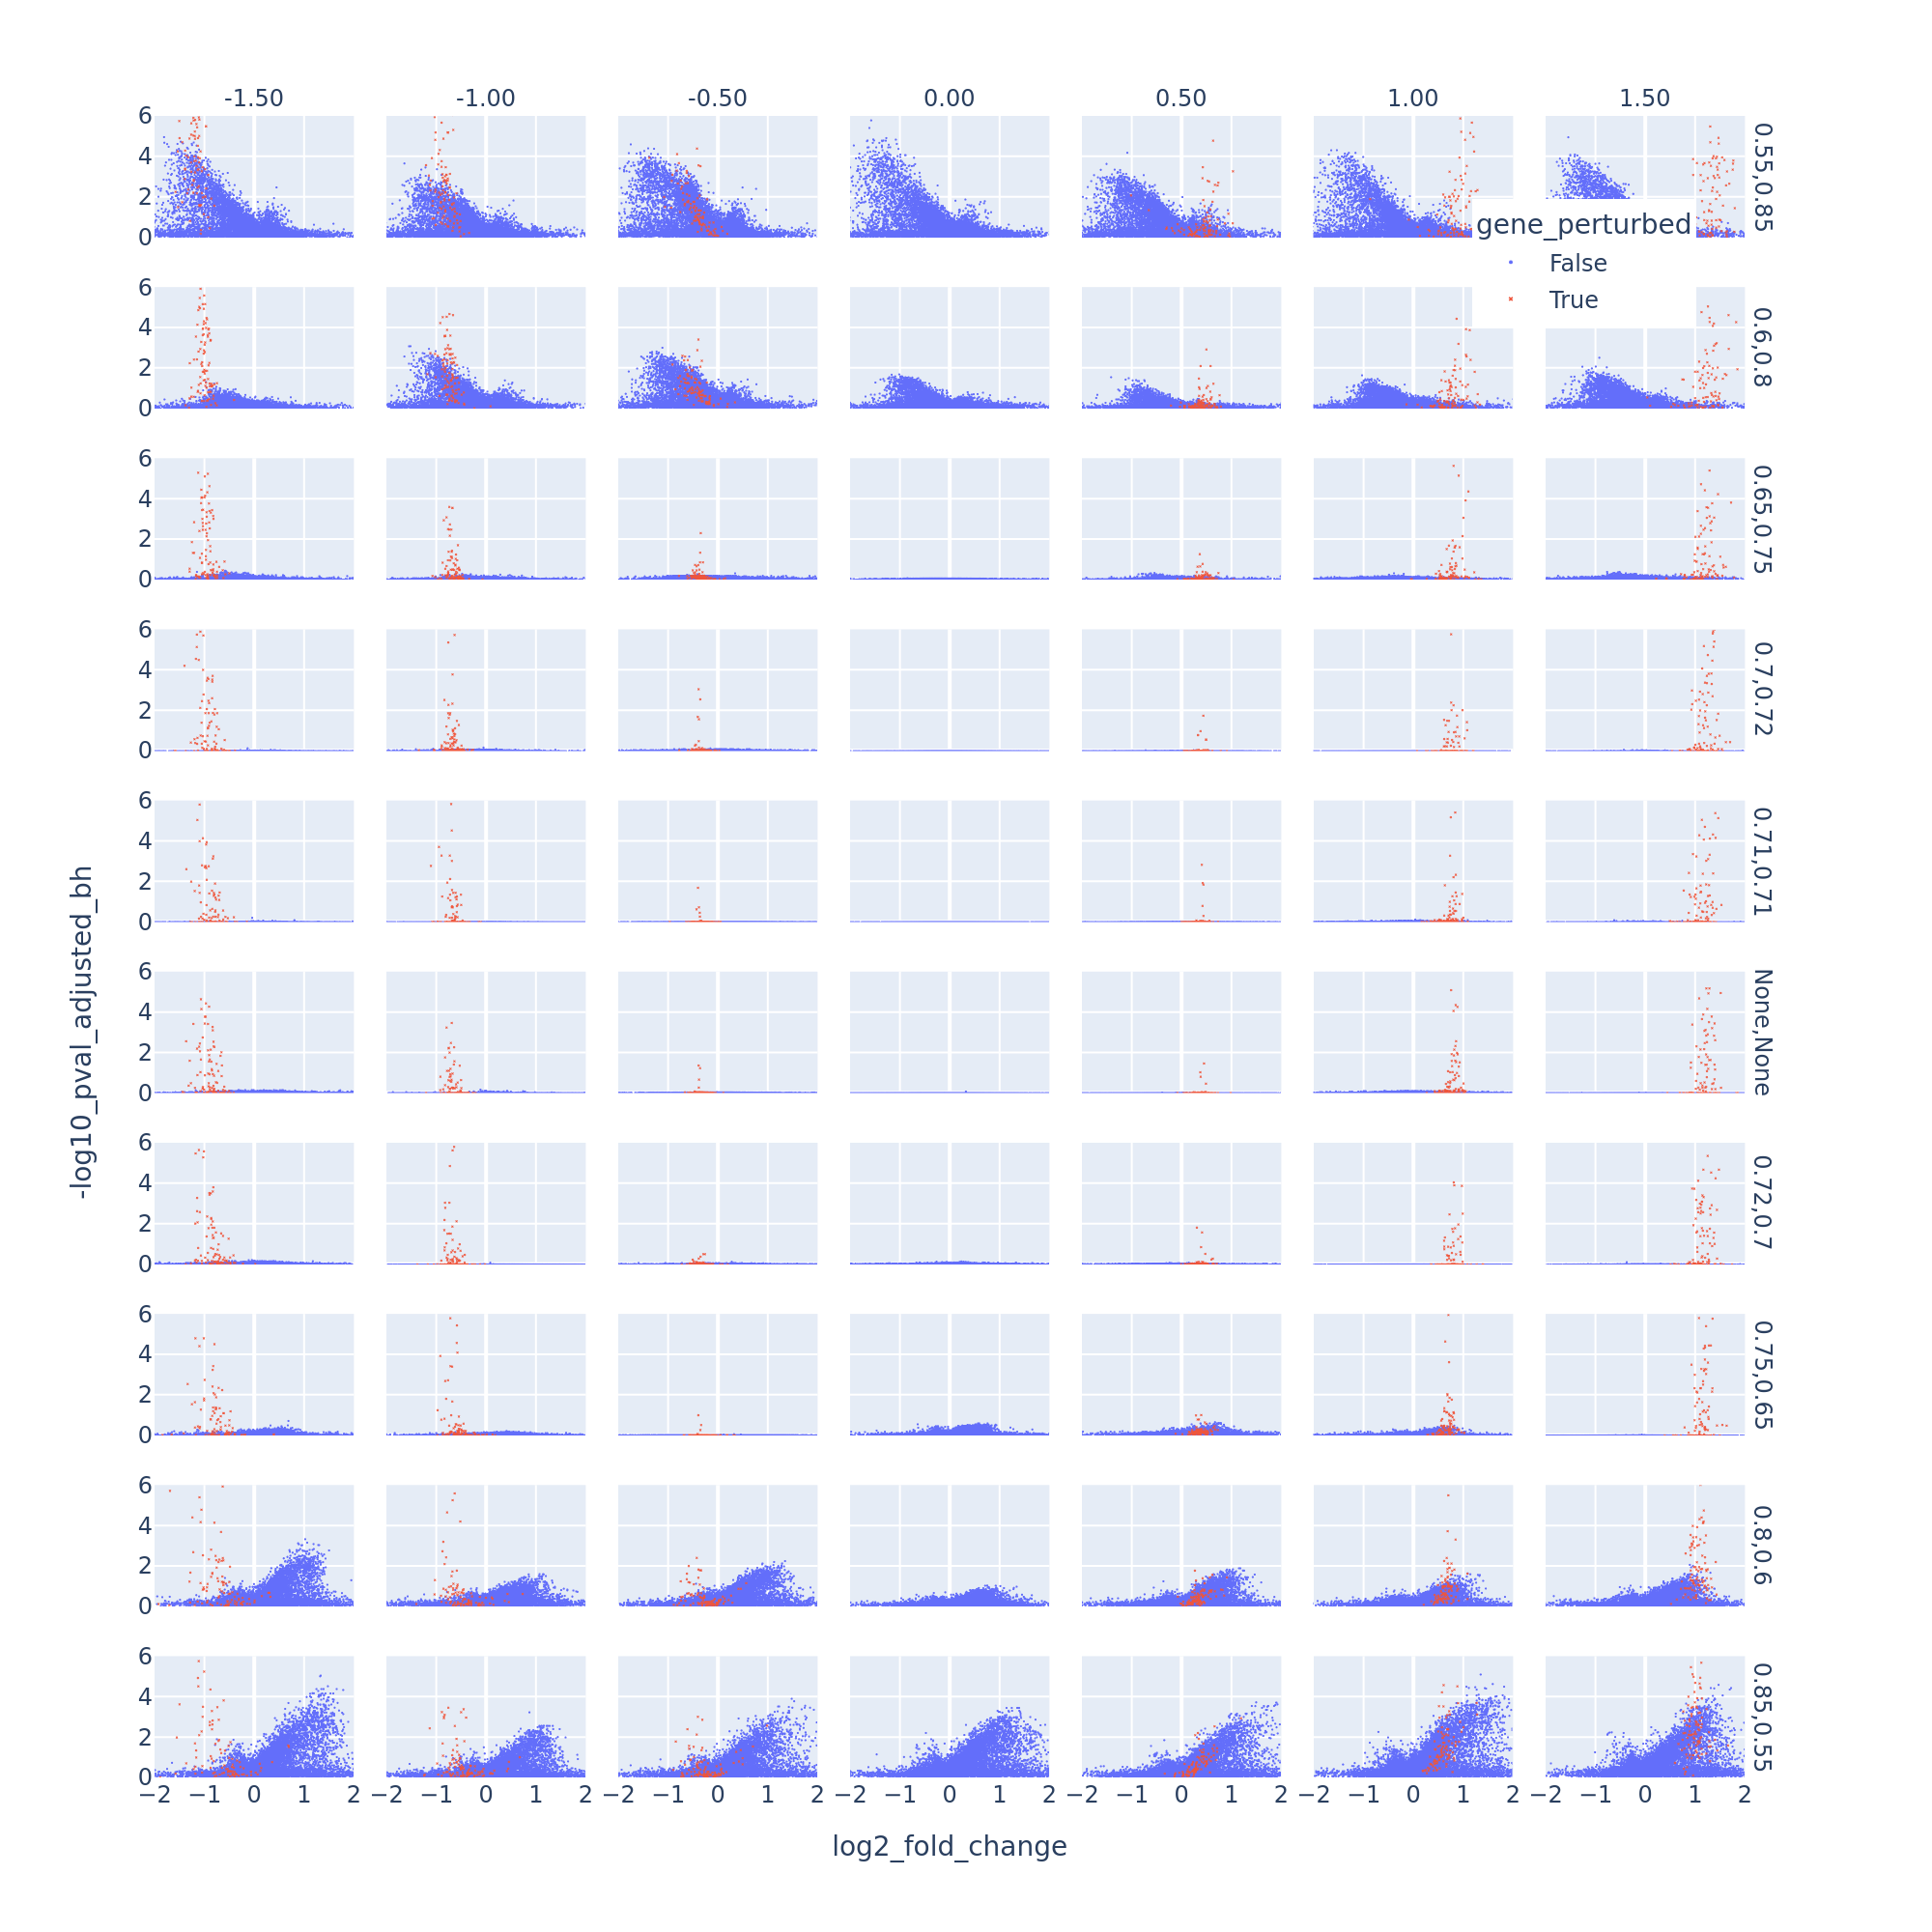

In [8]:
df_to_plot = df_gene_stats.xs("bulk", level="origin", drop_level=False)
fig = deg_analysis.make_volcano_grid_scatter(df_to_plot)
fig.show(renderer="png", scale=2)

## ROC, PPV, etc by p-value thresholds

In [22]:
score_column = "-log10_pval_signed_directional"
# score_column = "-log10_pval_adjusted_bh_signed_directional"

In [23]:
df = (
    df_gene_stats.loc[df_gene_stats.index.get_level_values("log2_fc") != "0.00"].xs(
        "malignant_cibersortx", level="origin", drop_level=False
    )
    #
)
df_roc_curves, df_roc_auc_scores = deg_analysis.calculate_roc(df, score_column)
df_precision_recall_curves, df_precision = deg_analysis.calculate_precision_and_recall(
    df, score_column
)

2023-06-02 04:17:36,833 - helpers.deg_analysis.computing_classifier_roc_precion_recall - DEBUG - calculating ROC curves
2023-06-02 04:17:36,834 - helpers.deg_analysis.computing_classifier_roc_precion_recall - DEBUG - grouping by ['origin', 'malignant_means', 'log2_fc', 'run_id']
2023-06-02 04:17:40,789 - helpers.deg_analysis.computing_classifier_roc_precion_recall - DEBUG - calculating precision-recall curves
2023-06-02 04:17:40,790 - helpers.deg_analysis.computing_classifier_roc_precion_recall - DEBUG - grouping by ['origin', 'malignant_means', 'log2_fc', 'run_id']
2023-06-02 04:17:43,841 - py.warnings - WARNING - /opt/conda/envs/deconv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


2023-06-02 04:17:44,001 - py.warnings - WARNING - /opt/conda/envs/deconv/lib/python3.11/site-packages/sklearn/metrics/_classif

### ROC (TPR & FPR)

In [24]:
deg_analysis.make_score_table(df_roc_auc_scores)

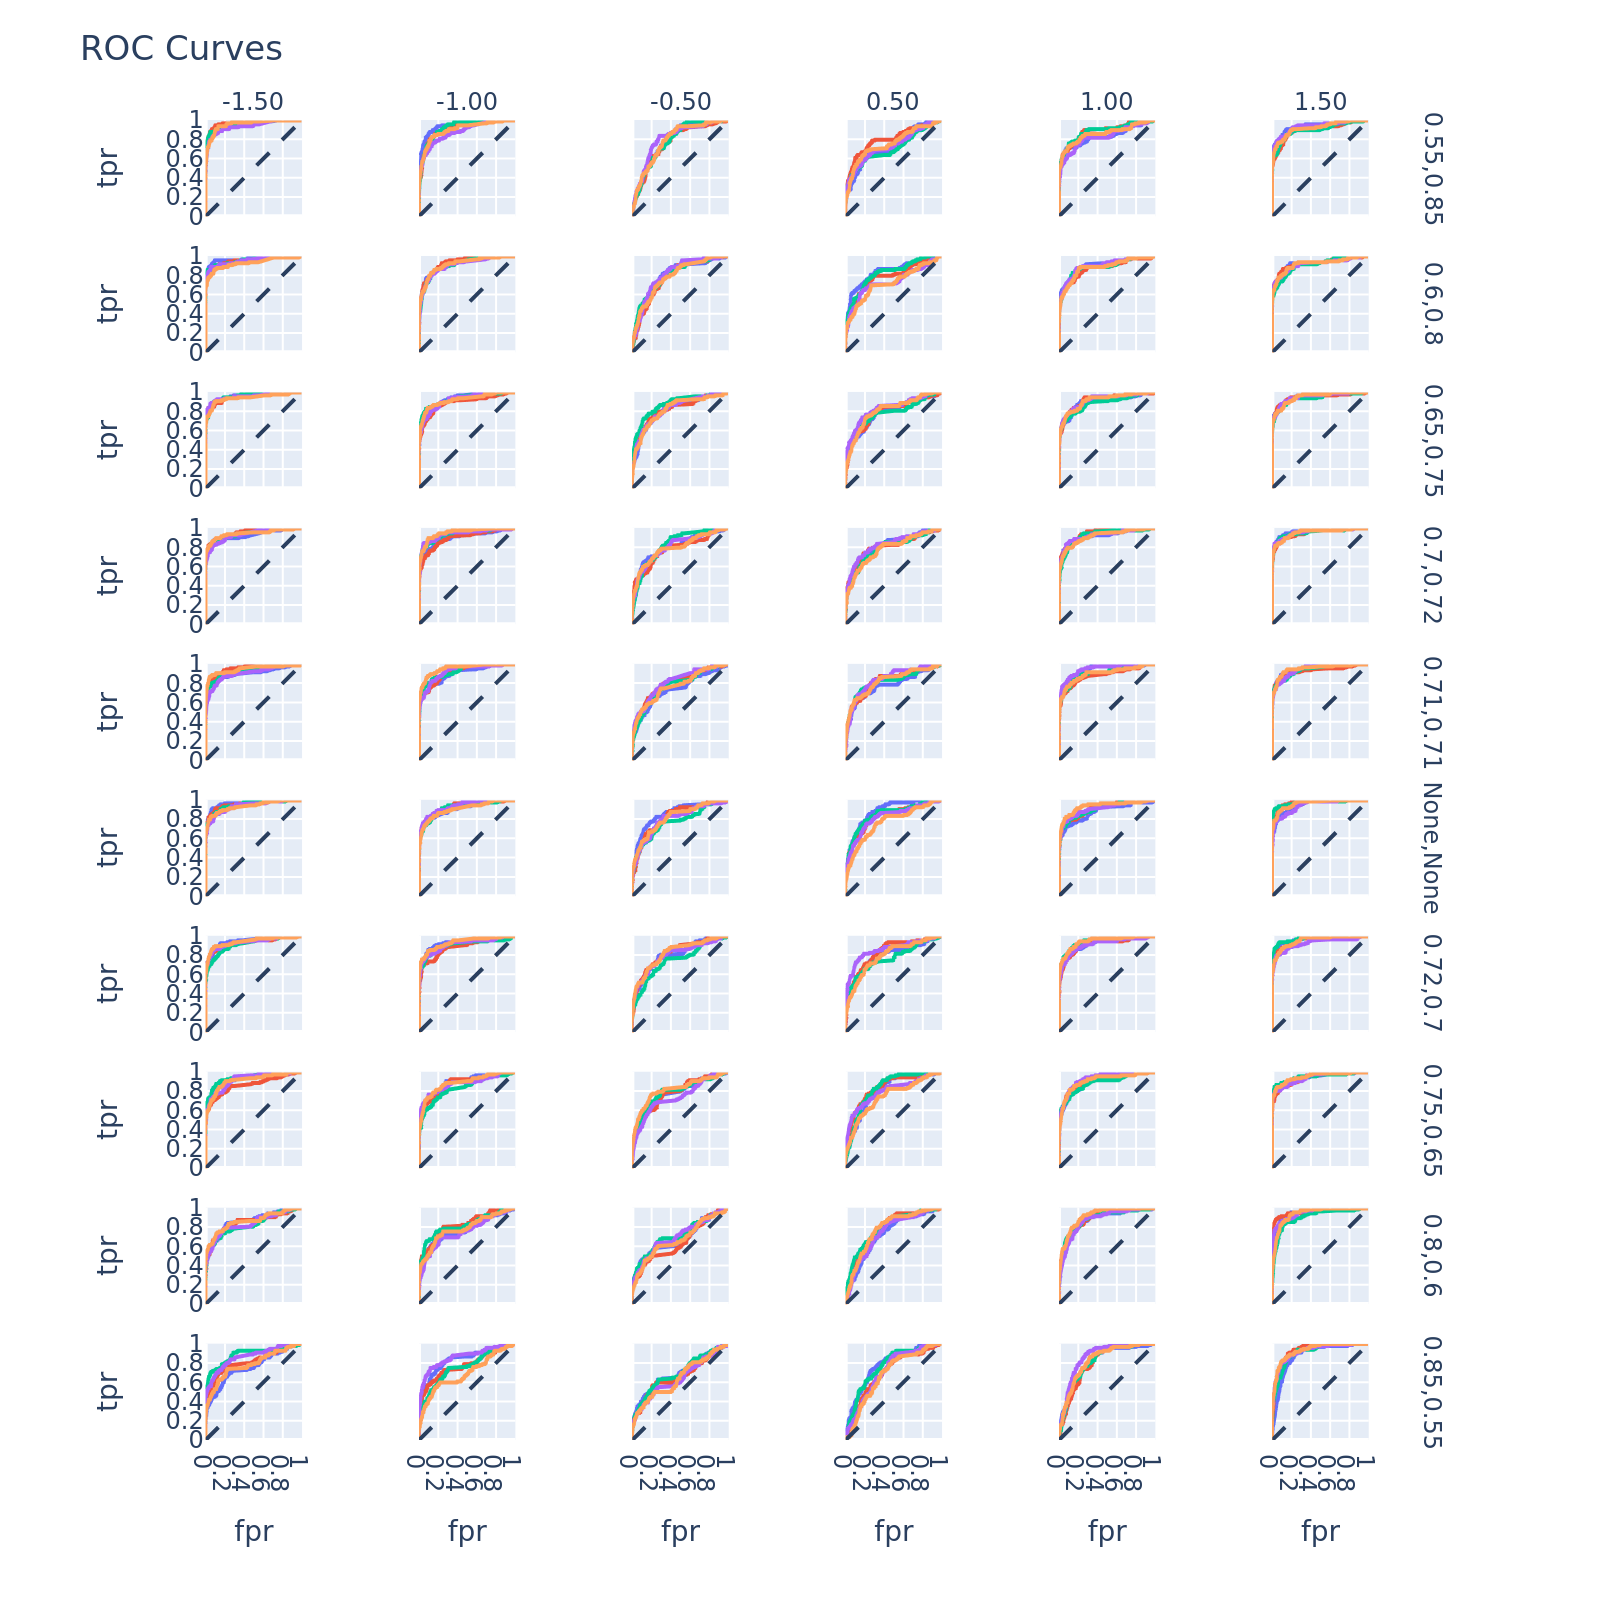

In [25]:
fig = deg_analysis.plot_roc(df_roc_curves)
fig.show(renderer="png", scale=2)

### PPV (precision)

In [26]:
deg_analysis.make_score_table(df_precision)

In [27]:
deg_analysis.make_score_table_with_stddev(df_precision)

2023-06-02 04:15:11,186 - helpers.deg_analysis.plotting_utils - DEBUG - middle_col=2
2023-06-02 04:15:11,186 - helpers.deg_analysis.plotting_utils - DEBUG - middle_row=5


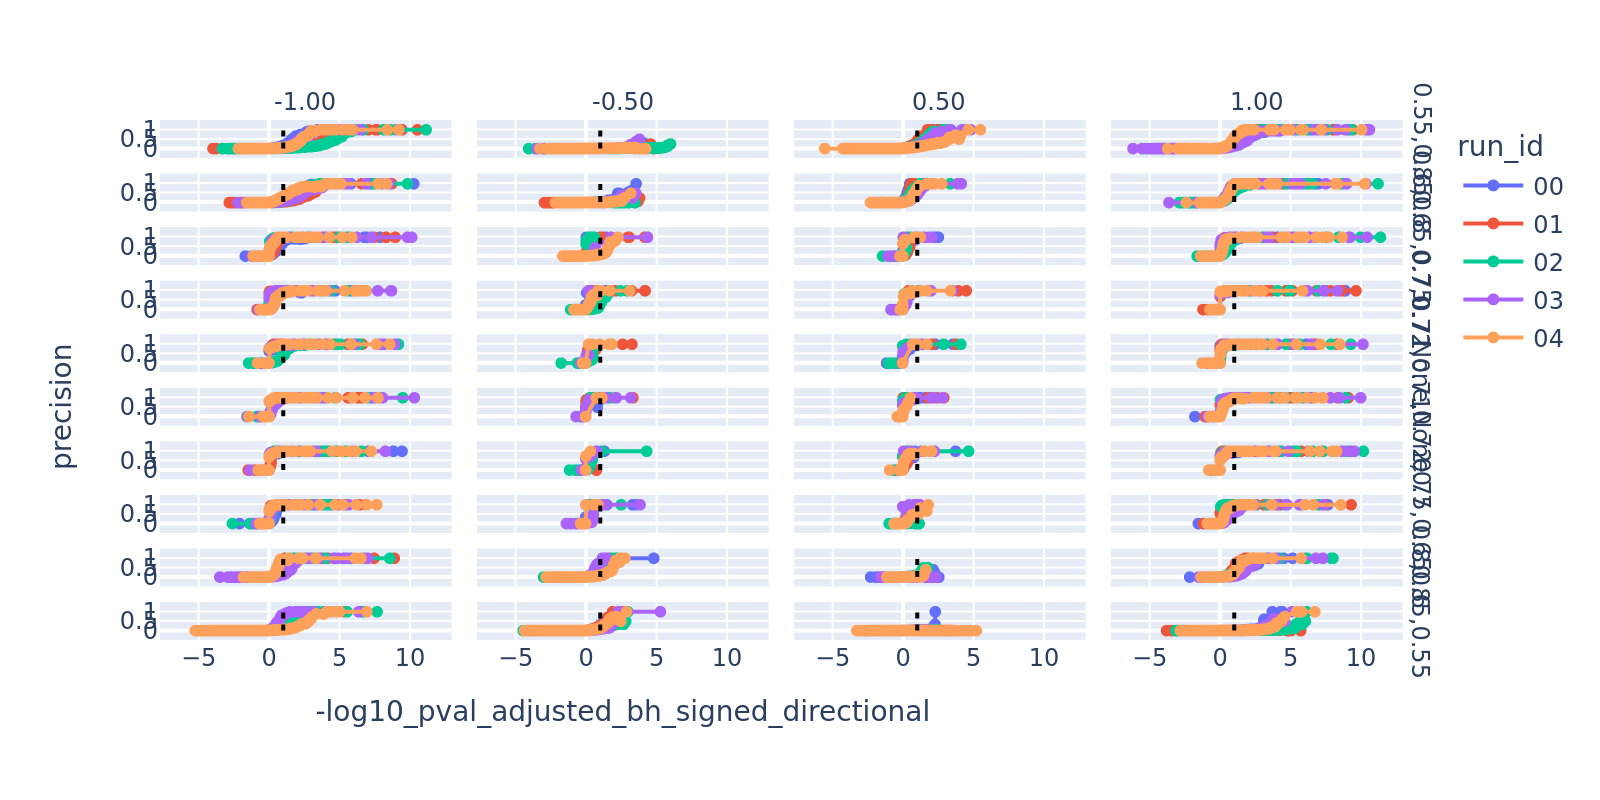

In [15]:
df_to_plot = (
    df_precision_recall_curves
    # .xs("None,None", level="malignant_means", drop_level=False)
    # .xs("1.50", level="log2_fc", drop_level=False)
    .loc[:, :, "-1.00":"1.00", :]
)
fig = deg_analysis.plot_metric_by_threshold(df_to_plot, score_column, "precision")
fig.update_layout(width=800, height=400)
fig.show(renderer="png", scale=2)
# fig

2023-06-02 04:15:23,665 - helpers.deg_analysis.plotting_utils - DEBUG - middle_col=2
2023-06-02 04:15:23,666 - helpers.deg_analysis.plotting_utils - DEBUG - middle_row=1


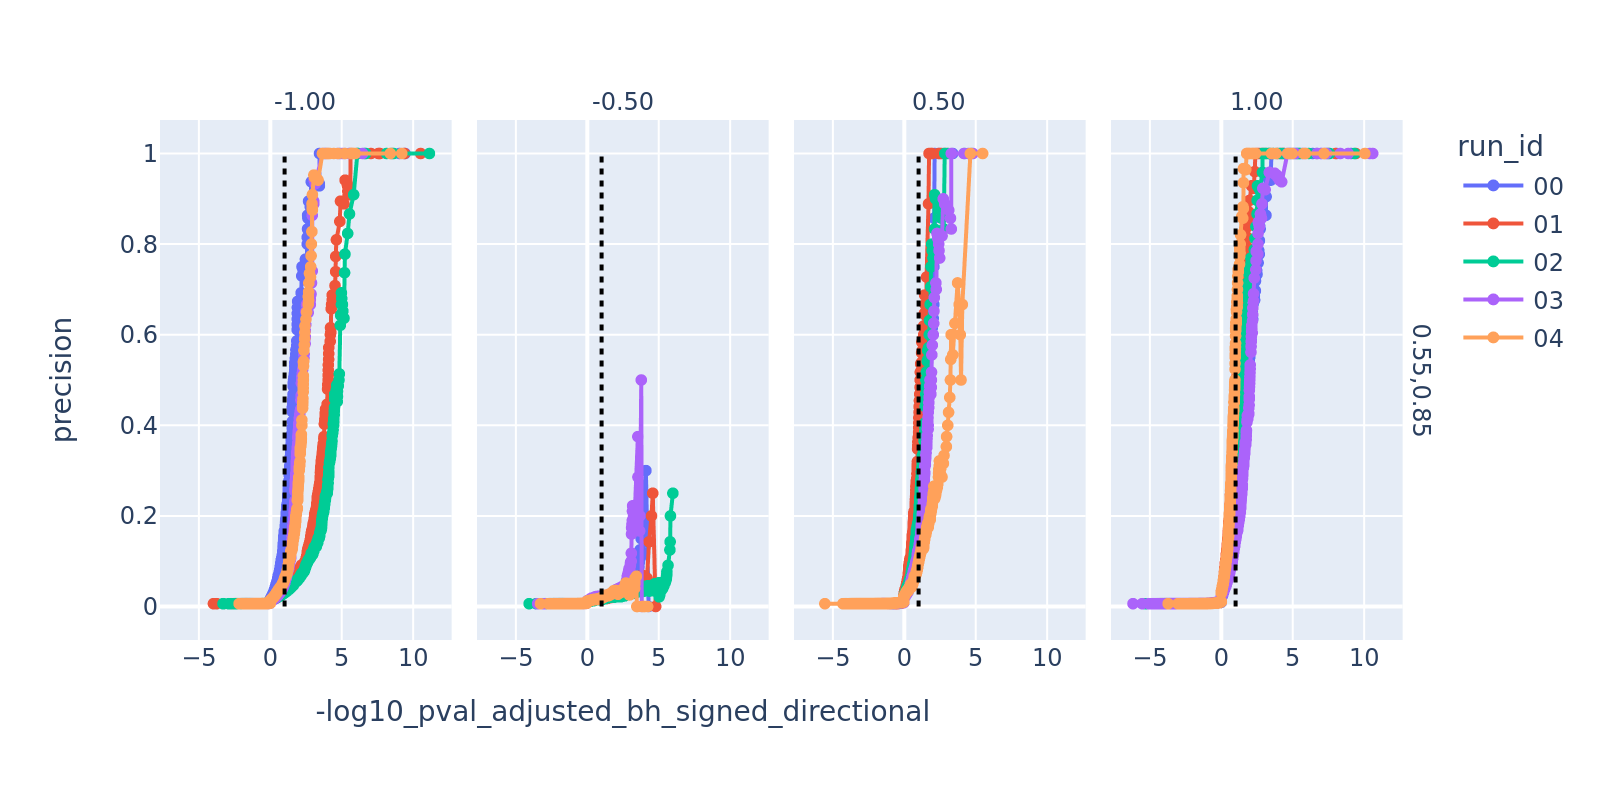

In [16]:
df_to_plot = df_precision_recall_curves.xs(
    "0.55,0.85", level="malignant_means", drop_level=False
).loc[:, :, "-1.00":"1.00", :]
fig = deg_analysis.plot_metric_by_threshold(df_to_plot, score_column, "precision")
fig.update_layout(width=800, height=400)
fig.show(renderer="png", scale=2)

2023-06-02 04:15:28,456 - helpers.deg_analysis.plotting_utils - DEBUG - middle_col=2
2023-06-02 04:15:28,457 - helpers.deg_analysis.plotting_utils - DEBUG - middle_row=1


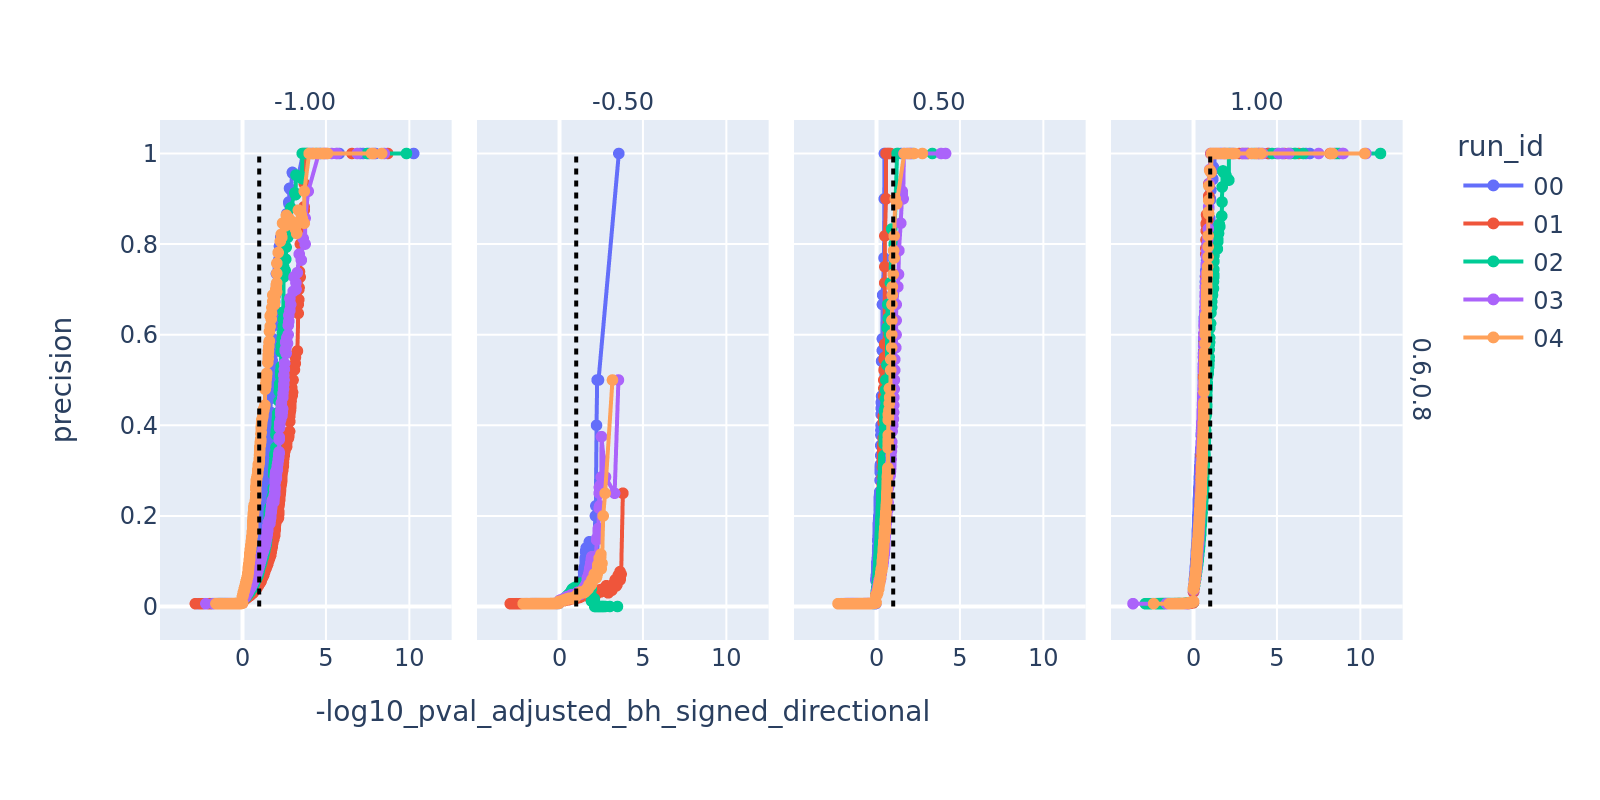

In [17]:
df_to_plot = df_precision_recall_curves.xs(
    "0.6,0.8", level="malignant_means", drop_level=False
).loc[:, :, "-1.00":"1.00", :]
fig = deg_analysis.plot_metric_by_threshold(df_to_plot, score_column, "precision")
fig.update_layout(width=800, height=400)
fig.show(renderer="png", scale=2)

2023-06-02 04:15:33,202 - helpers.deg_analysis.plotting_utils - DEBUG - middle_col=2
2023-06-02 04:15:33,203 - helpers.deg_analysis.plotting_utils - DEBUG - middle_row=4


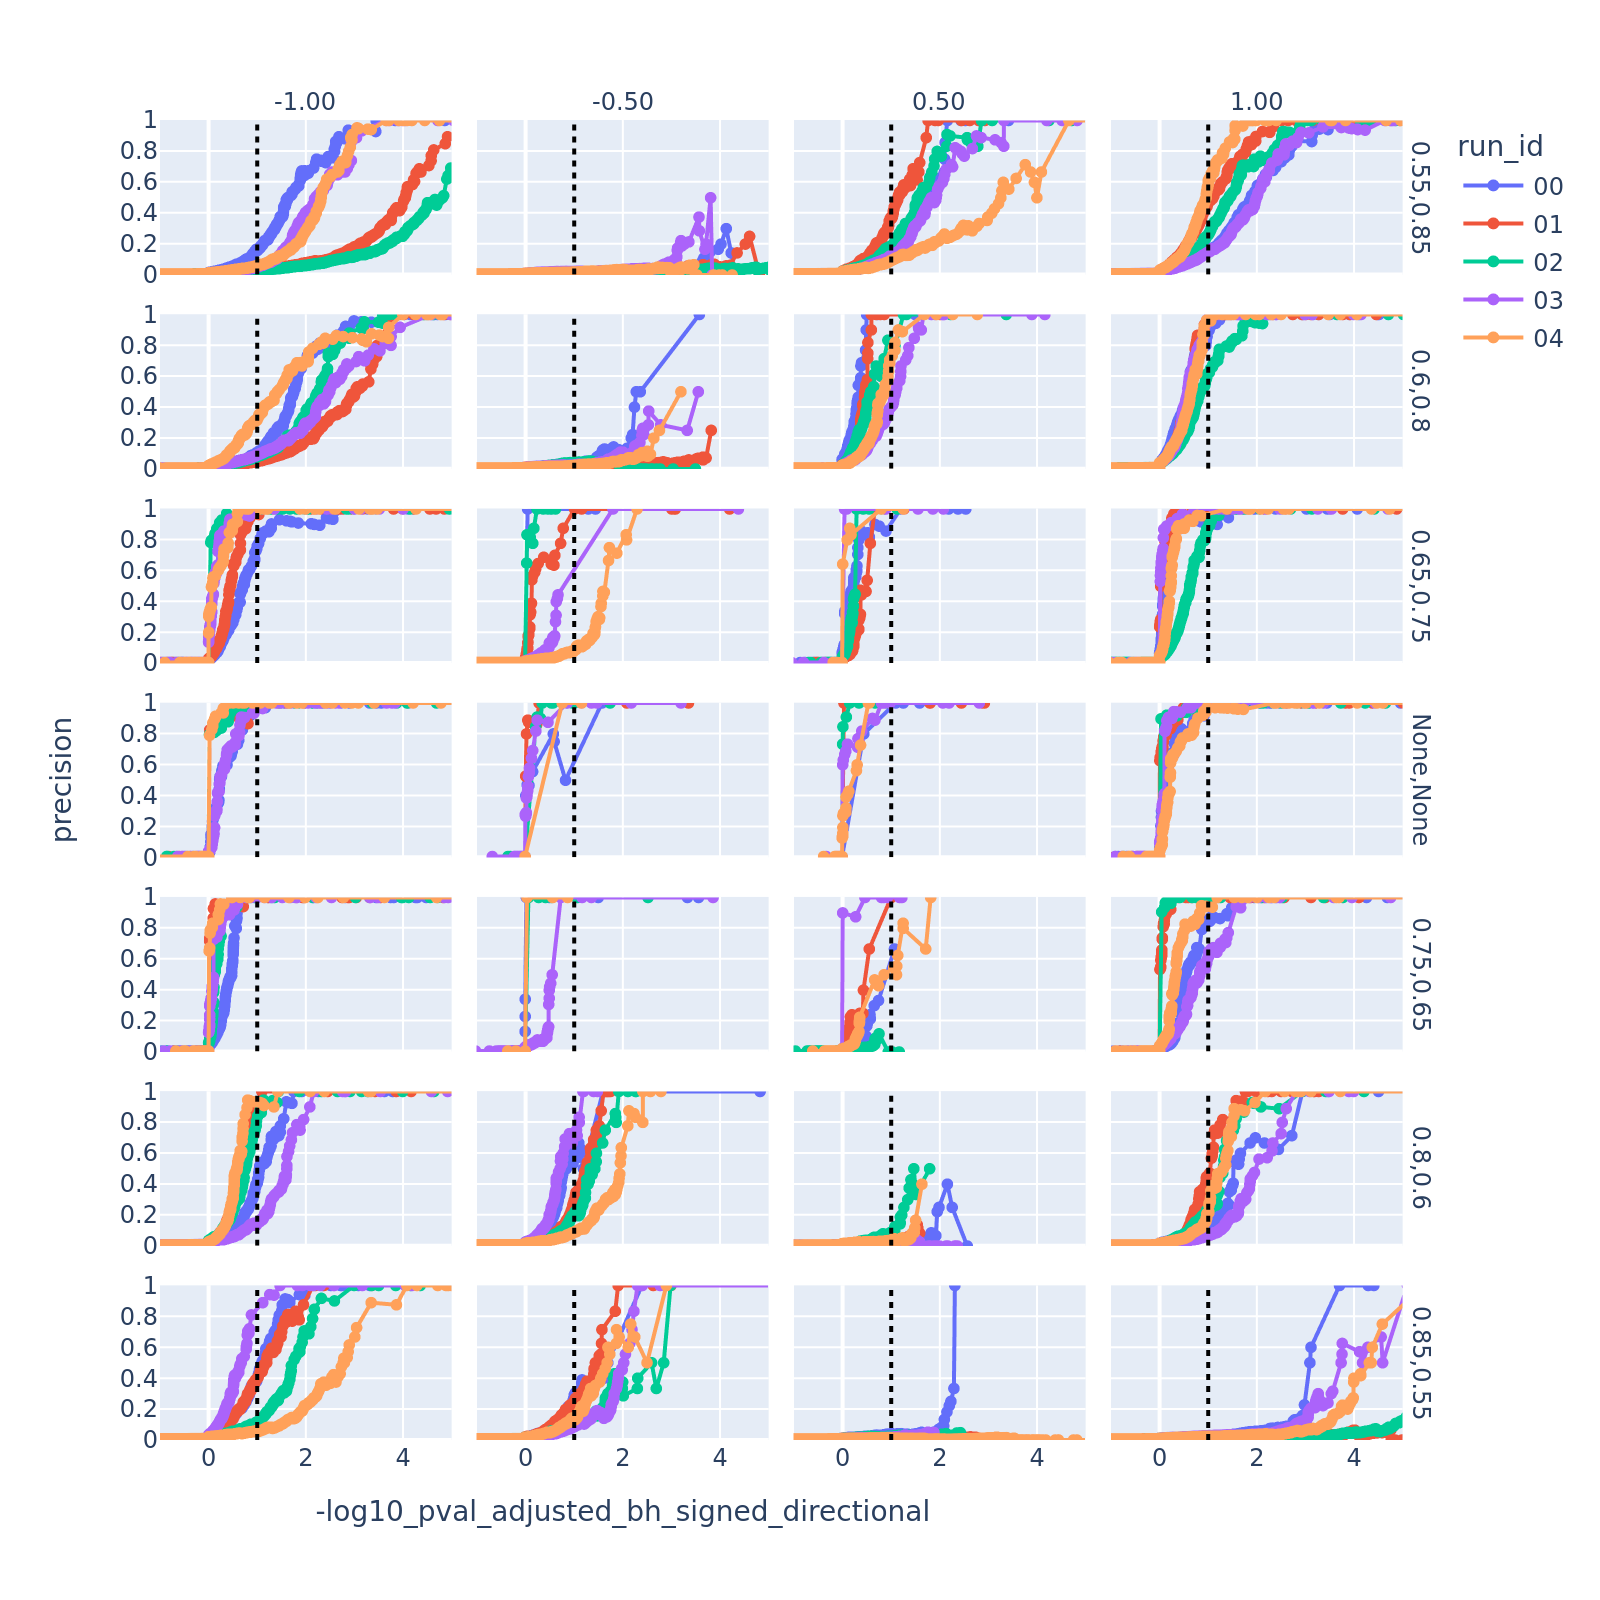

In [18]:
def filter_stuff(df):
    df = df.loc[
        df.index.get_level_values("malignant_means").isin(
            # ["0.55,0.85", "0.65,0.75", "None,None", "0.75,0.65", "0.85,0.55"]
            ["0.55,0.85", "0.6,0.8", "0.65,0.75", "None,None", "0.75,0.65", "0.8,0.6", "0.85,0.55"]
        )
    ]
    df = df.loc[:, :, "-1.00":"1.00"]
    return df


fig = deg_analysis.plot_metric_by_threshold(
    filter_stuff(df_precision_recall_curves),
    score_column,
    "precision",
)
fig.update_layout(width=800, height=800)
fig.update_xaxes(range=[-1, 5])
fig.update_yaxes(range=[0, 1], dtick=0.2)
fig.show(renderer="png", scale=2)

### Precision & Recall curves

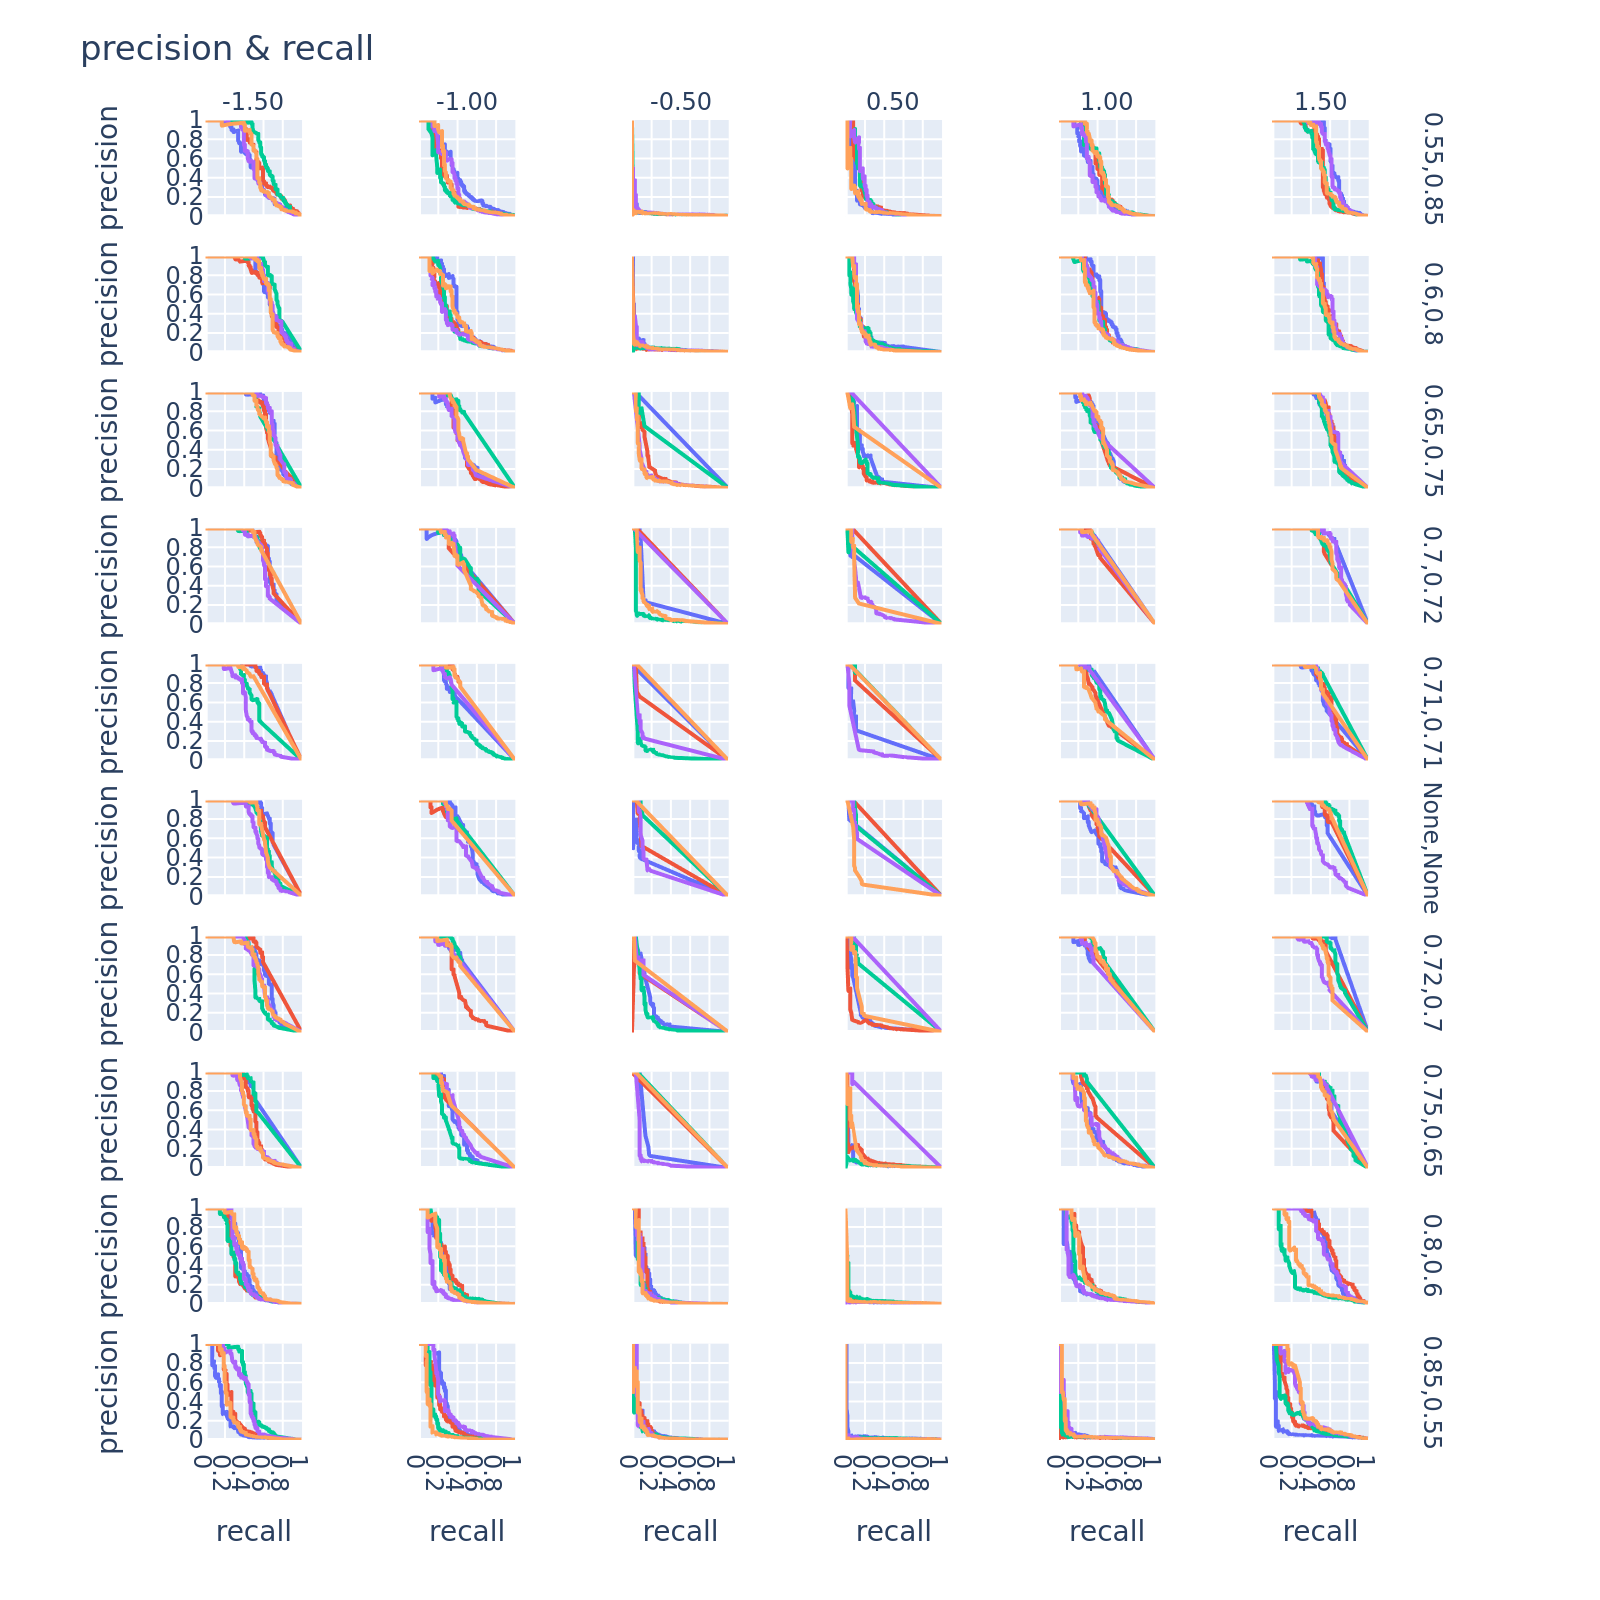

In [19]:
fig = deg_analysis.plot_precision_recall_curve(df_precision_recall_curves)
fig.show(renderer="png", scale=2)

### FPR under no perturbation (don't care)

2023-06-02 04:16:06,227 - helpers.deg_analysis.computing_classifier_roc_precion_recall - DEBUG - calculating ROC curves
2023-06-02 04:16:06,228 - helpers.deg_analysis.computing_classifier_roc_precion_recall - DEBUG - grouping by ['origin', 'malignant_means', 'log2_fc', 'run_id']
2023-06-02 04:16:06,435 - py.warnings - WARNING - /opt/conda/envs/deconv/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning:

No positive samples in y_true, true positive value should be meaningless


2023-06-02 04:16:06,439 - py.warnings - WARNING - /opt/conda/envs/deconv/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning:

No positive samples in y_true, true positive value should be meaningless


2023-06-02 04:16:06,443 - py.warnings - WARNING - /opt/conda/envs/deconv/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning:

No positive samples in y_true, true positive value should be meaningless


2023-06-02 0

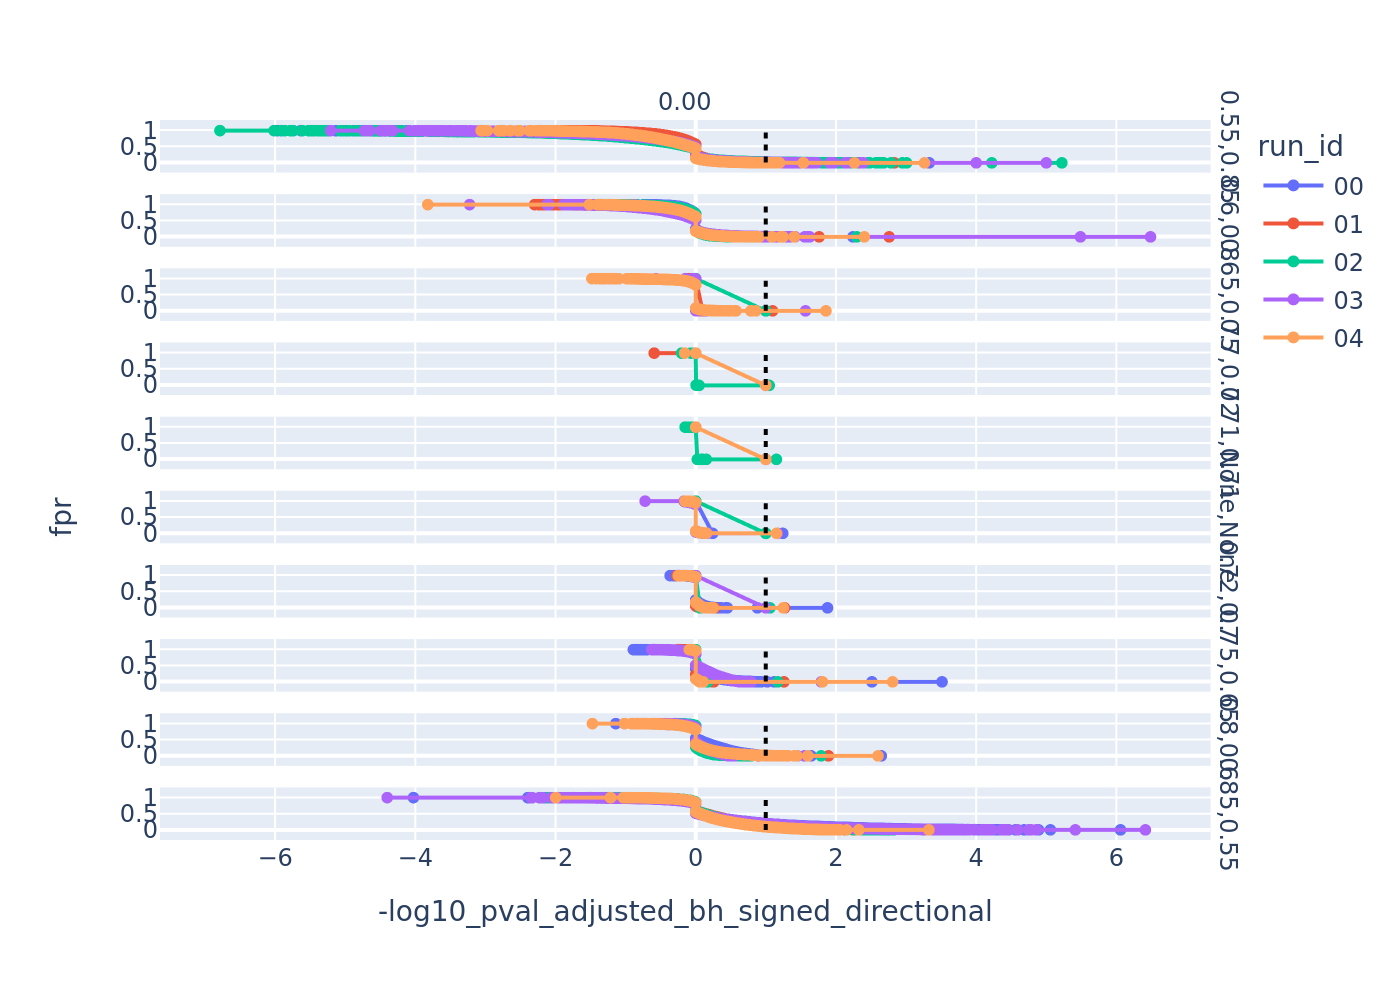

In [20]:
"""
    # .xs(slice("0.65,0.75", None, 3), level="malignant_means", drop_level=False)
"""
subset = df_gene_stats.xs("malignant_cibersortx", level="origin", drop_level=False).xs(
    "0.00", level="log2_fc", drop_level=False
)
df_to_plot, _ = deg_analysis.calculate_roc(subset, score_column)
fig = deg_analysis.plot_metric_by_threshold(df_to_plot, score_column, "fpr")
fig.show(renderer="png", scale=2)

## checking p-values

In [21]:
columns = [
    "pval",
    # "-log10_pval",
    # "-log10_pval_signed_directional",
    # "pval_adjusted_bh",
    # "-log10_pval_adjusted_bh",
    # "-log10_pval_adjusted_bh_signed_directional",
]

# subset_gene_stats = df_gene_stats.loc["malignant_cibersortx", "0.72,0.7", "1.00"]
subset_gene_stats = pd.read_parquet(
    # path_root / "gene_stats" / "malignant_cibersortx" / "0.72,0.7" / "1.00" / "gene_stats.parquet"
    path_root
    / "experiment_id=264/malignant_means=0.72,0.7/log2_fc=1.00/run_id=04/deg_analysis/gene_stats_malignant_cibersortx.parquet"
)

print(subset_gene_stats.shape)

# subset_gene_stats[columns].sort_values(by="-log10_pval_adjusted_bh", ascending=False)
print(subset_gene_stats["significant_bh_fdr=0.10"].value_counts())

# plotly line plots of pvals
import plotly.express as px

df_to_plot = subset_gene_stats.sort_values("pval").reset_index()
df_to_plot["perturbed"] = df_to_plot["perturbed"].astype(int)
df_to_plot["size"] = df_to_plot["perturbed"].apply(lambda x: 10 if x == 1 else 5)

fig = px.scatter(
    df_to_plot,
    x="gene_symbol",
    y=columns,
    # use "o" marker if "perturbed" column is True
    color="perturbed",
    size="perturbed",
)
fig

(16063, 10)
False    16036
True        27
Name: significant_bh_fdr=0.10, dtype: int64
